In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

### Подготовка данных для использования
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [2]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

In [3]:
BATCH_SIZE = 64

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([0, 3, 1, 7, 3, 6, 1, 9, 5, 6, 3, 8, 7, 6, 4, 0, 8, 6, 2, 4, 1, 2, 3, 4,
        8, 5, 7, 2, 3, 8, 0, 8, 6, 4, 9, 7, 6, 9, 6, 9, 9, 3, 7, 1, 6, 3, 7, 0,
        6, 4, 2, 6, 1, 8, 0, 8, 3, 7, 1, 4, 4, 1, 5, 9])

In [6]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

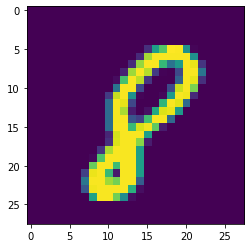

In [7]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Построим нейронную сеть, чтобы для решения задачи бинарной классфикации (является ли цифра 9-кой или нет)

In [8]:
class IsOne(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 64)
        self.Linear3 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x).squeeze(1)
        x = self.Sigmoid(x)
        return x

In [9]:
model = IsOne()

### Функция, вычисляющая лосс

In [10]:
def loss_function(true, pred):
    loss = torch.nn.BCELoss()
    return loss(pred, true)

### Оптимизатор

In [11]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

### Построим процесс обучения нейронной сети

In [12]:
NUM_EPOCHS = 100
WANTED_LABEL = 9

In [13]:
train_loss = []
test_loss = []
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        model.zero_grad()
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
    train_loss.append(train_loss_epoch)
    model.train(False)
    for X, y in test_dataloader:
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    # print(epoch, train_loss[-1], test_loss[-1])

100%|██████████| 100/100 [17:45<00:00, 10.66s/it]


<AxesSubplot:>

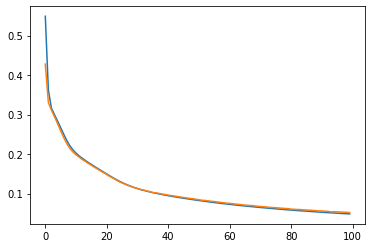

In [14]:
sns.lineplot(x=range(len(train_loss)), y=train_loss)
sns.lineplot(x=range(len(test_loss)), y=test_loss)

In [15]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X).detach().numpy())
    reals.append((y==WANTED_LABEL).int().numpy())

In [16]:
preds = (np.concatenate(preds)>=0.5).astype(int)

In [17]:
reals = np.concatenate(reals)

In [18]:
from sklearn.metrics import accuracy_score, f1_score

In [19]:
accuracy_score(preds, reals), f1_score(reals, preds)

(0.9850761217948718, 0.924095771777891)

### Домашняя работа
Изменить нейронную сеть следующим образом:
 - Чтобы она решала задачу не бинарной классификации, а многоклассовой (Для этого нужно использовать другую лосс функцию и функцию активации на выходе)
 - Чтобы в ней было не 2 скрытых слоя, а три
 - Чтобы кол-во нейронов подставлялось через массив, поданный при инициализации класса модели
 - Чтобы происходил dropout (вероятность 0.3) до первого скрытого слоя. Показать, как это изменение повлияло на результат работы модели на тестовой выборке.
 - Посчитать метрики классификации через classification report (sklearn) для каждого класса

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report

In [21]:
# Подготовка данных для использования
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=ToTensor()
)

In [22]:
BATCH_SIZE = 64

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [24]:
# Целевое значение
next(iter(train_dataloader))[1]

tensor([3, 6, 9, 6, 7, 6, 6, 4, 4, 1, 5, 5, 4, 7, 7, 1, 9, 1, 9, 2, 2, 2, 4, 3,
        9, 8, 9, 9, 3, 5, 5, 1, 8, 4, 3, 7, 5, 8, 6, 4, 2, 7, 4, 9, 7, 0, 1, 0,
        9, 6, 5, 9, 0, 7, 8, 2, 6, 3, 7, 0, 2, 2, 1, 3])

In [25]:
# Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

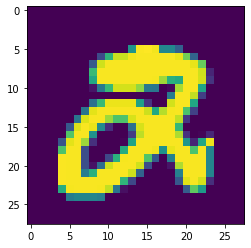

In [26]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

## Построим нейронную сеть, чтобы для решения задачи многоклассовой классификации

In [27]:
class MnistClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        
        self.dropout_prob = dropout_prob
        
        # Первый слой
        self.fc1 = torch.nn.Linear(input_dim, hidden_dims[0])
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(p=dropout_prob)
        
        # Второй слой
        self.fc2 = torch.nn.Linear(hidden_dims[0], hidden_dims[1])
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(p=dropout_prob)
        
        # Третий слой
        self.fc3 = torch.nn.Linear(hidden_dims[1], hidden_dims[2])
        self.relu3 = torch.nn.ReLU()
        self.dropout3 = torch.nn.Dropout(p=dropout_prob)
        
        # Выходной слой
        self.out = torch.nn.Linear(hidden_dims[2], output_dim)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        
        # Применяем первый слой, активацию и dropout
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
    
        # Применяем второй слой, активацию и dropout
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
    
        # Применяем третий слой, активацию и dropout
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
    
        # Применяем выходной слой и softmax
        x = self.out(x)
        x = self.softmax(x)
    
        return x

In [28]:
model = MnistClassifier(input_dim=28*28, hidden_dims=[256, 128, 64], output_dim=10, dropout_prob=0.3)

### Функция, вычисляющая лосс

In [29]:
def loss_function(pred, true):
    loss = torch.nn.CrossEntropyLoss()
    return loss(pred, true)

### Построим процесс обучения нейронной сети


In [30]:
NUM_EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MnistClassifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [31]:
train_loss = []
test_loss = []

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        model.zero_grad()
        predictions = model(X)
        loss_value = F.cross_entropy(predictions, y.flatten().long())
        loss_value.backward()
        train_loss_epoch += loss_value.item() / len(train_dataloader)
        optimizer.step()
        
    train_loss.append(train_loss_epoch)
    model.train(False)
    
    with torch.no_grad():
        model.eval()
        test_loss_epoch = 0
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            predictions = model.forward(X)
            loss_value = loss_function(predictions, y.squeeze().to(torch.long))
            test_loss_epoch += loss_value.item()/len(test_dataloader)
        
    test_loss.append(test_loss_epoch)

100%|██████████| 100/100 [18:44<00:00, 11.24s/it]


<AxesSubplot:>

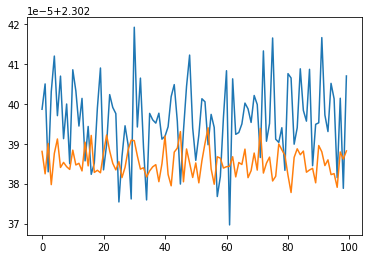

In [32]:
sns.lineplot(x=range(len(train_loss)), y=train_loss)
sns.lineplot(x=range(len(test_loss)), y=test_loss)

In [33]:
preds = []
reals = []
for X, y in test_dataloader:
  preds.append(torch.argmax(model(X), dim=1).detach().numpy())
  reals.append(y.numpy())

In [34]:
preds = np.concatenate(preds)

In [35]:
reals = np.concatenate(reals)

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(reals, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.10      1.00      0.18       980
           1       0.00      0.00      0.00      1133
           2       0.00      0.00      0.00      1030
           3       0.00      0.00      0.00      1008
           4       0.00      0.00      0.00       981
           5       0.00      0.00      0.00       889
           6       0.00      0.00      0.00       957
           7       0.00      0.00      0.00      1027
           8       0.00      0.00      0.00       971
           9       0.00      0.00      0.00      1008

    accuracy                           0.10      9984
   macro avg       0.01      0.10      0.02      9984
weighted avg       0.01      0.10      0.02      9984



Выводы.

Результаты метрик для первой модели выглядят гораздо лучше, чем для второй модели. В первой модели точность составляет 0.98, а полнота - 0.92. Это говорит о том, что модель правильно классифицирует большинство изображений и способна распознать многие изображения, которые относятся к классу.

Вторая модель, с другой стороны, имеет очень низкие результаты метрик. Точность для каждого класса составляет 0.00, что означает, что модель не может корректно классифицировать изображения ни для одного из классов. 

Из всего выше сказанного можно заключить, что первая модель является более эффективной, чем вторая модель, в распознавании изображений.